Built using 'webguienv' environment (I always note env because ya never know!)

First set up API Keys and packages needed and define OpenAI client

In [1]:
from IPython.display import clear_output
import json
from openai import OpenAI
import requests
import time

path = "config.json"

with open(path, "r") as f:
    config = json.load(f)
    
openai_api_key = config["OPENAI_API_KEY"] 
openai_admin_key = config["OPENAI_ADMIN_KEY"]


client = OpenAI(api_key=openai_api_key)

Here we define the buyer agent's system, tool/function to accept or offer, and basic method to call the agent

In [2]:
def buyer_system():
    system = "You are John. You are playing an economics game. There are 5 buyers and 5 sellers. You are a buyer and you want to buy three oranges. \
You will buy them one at a time. You play this game in descrete steps. The key peices of information are prices (P) and your private value (V). \
If you buy at price P, you will get a payoff of V - P. You want to maximize your payoff. You have five rounds to buy three oranges, then the game is done. \
At each step you will be given the following information about the game state: \
1. The price (P) of the lowest three 'asks' to sell if there are any. \
2. The price (P) of the highest three 'offers' to buy if there are any. \
3. Your private value of one orange (V). \
4. The current history of completed transactions in terms of the price at which an orange was sold. \
5. Your private history of how many oranges you have bought so far including price paid and value. \
6. Your current state which includes how many oranges you still need to buy and whether you \
have an existing offer outstanding that has not been accepted yet. \
7. The current round number. \
At each step you decide whether to post an updated offer - 'offer', or to accept the lowest existing ask price - 'accept'. \
You will use a function 'my_choice' to decide what to do. You reply with the 'choice' variable as either 'offer' or 'accept'. \
You also need to provide a price, but the price is only used if you \
choose 'offer', and that is a 'price' variable that is the price you are willing to pay which is below your current value. "
    
    return system
 
 

buyer_fns = [{
    "type": "function",
    "function":{
        "name": "my_choice",
        "description": "Choose which option to choose, accept lowest ask or offer. If you offer you must also give an offer price.",
        "parameters": {
            "type": "object",
            "properties": {
                "choice": {
                    "type": "string",
                    "description": "Your choice - offer or accept",
                    "enum":[
                        "offer", 
                        "accept" 
                        ]
                },
                "price": {
                    "type": "number",
                    "description": "Price you are willing to offer if your 'choice' is 'offer'."
                }
            },
            "required": ["choice", "price"],
            "additionalProperties": False
        },
        "strict": True
    }
}]


# default summary with 'None' user instruction
def buyer_reply(messages):
    completion = client.chat.completions   
    response = completion.create(model='gpt-4o-mini', # 'gpt-3.5-turbo-16k' for longer context
                            messages=messages, 
                            temperature=1,
                            tools=buyer_fns,
                            )
    answer = response.choices[0].message
    return answer 

Here we define the seller agent's system prompt, function/tool, and method to call them and get reply

In [3]:
def seller_system():
    system = "You are John. You are playing an economics game. There are 5 buyers and 5 sellers. You are a seller and you want to sell three oranges. \
You will sell them one at a time. You play this game in descrete steps. The key peices of information are prices (P) and your private cost (C). \
If you sell at price P, you will get a payoff of P - C. You want to maximize your payoff. You have five rounds to sell your oranges then the game is done. \
At each step you will be given the following information about the game state: \
1. The price (P) of the lowest three 'asks' to sell if there are any. \
2. The price (P) of the highest three 'offers' to buy if there are any. \
3. Your private cost of one orange (C). \
4. The current history of completed transactions in terms of the price at which an orange was sold. \
5. Your private history of how many oranges you have sold so far including price sold and cost. \
6. Your current state which includes how many oranges you still need to sell and whether you \
have an existing ask outstanding that has not been accepted yet. \
7. The current round number. \
At each step you decide whether to post an updated ask - 'ask', or to accept the highest existing offer price - 'accept'. \
You will use a function 'my_choice' to decide what to do. You reply with the 'choice' variable as either 'ask' or 'accept'. \
You also need to provide a price that will only be used if \
you choose 'ask' and it is a 'price' variable that is the price you are willing to take which is above your current cost."
    
    return system
 

seller_fns = [{
    "type": "function",
    "function": {
        "name": "my_choice",
        "description": "Choose which option to choose, accept highest offer or ask. If you ask you must also give an ask price.",
        "parameters": {
            "type": "object",
            "properties": {
                "choice": {
                    "type": "string",
                    "description": "Your choice - ask or accept",
                    "enum":[
                        "ask", 
                        "accept" 
                        ]
                },
                "price": {
                    "type": "number",
                    "description": "Price you are willing to take."
                }
            },
            "required": ["choice", "price"],
            "additionalProperties": False
        },
        "strict": True
    }
}]


# default summary with 'None' user instruction
def seller_reply(messages):
    completion = client.chat.completions  
    response = completion.create(model='gpt-4o-mini', # 'gpt-3.5-turbo-16k' for longer context
                            messages=messages, 
                            temperature=1,
                            tools=seller_fns,
                            )
    answer = response.choices[0].message
    return answer 

Here we define our Buyer class

In [4]:
class Buyer():
    def __init__(self, name, values, game): 
        self.name = name # buyer ID
        self.values = values # buyer valuations of goods - will be set by game set up 
        self.inventory = 0 # inventory of goods bought - basically part of agents memory
        self.history = [] # transactions - again a memory component
        self.outstanding_offer = False # is an offer outstanding?
        self.outstanding_offer_price = 0 # outstanding offer price if there is one (default to zero as place holder)
        self.current_value = self.values[self.inventory] # picks out current value of values based on inventory - so if haven't bought any then value of next is 0 entry in values

        self.game = game

    def change_state(self):
        # remove buyer if they have bought all goods for which they have values (i.e., length of game)
        if self.inventory == len(self.values):
            self.game.buyer_remove(self) 
        
    def update(self, price):
        #add transaction history, update inventory, reset outstnding offer, 
        # check change state, update current value
        self.history.append({'price': price, 'value': self.values[self.inventory]})
        self.inventory += 1 
        self.outstanding_offer = False
        self.outstanding_offer_price = 0
        self.change_state()
        if self.inventory < 3:
            self.current_value = self.values[self.inventory] 
        
        
    def offer(self, price):
        # set outstanding to true, set offer price (from llm response), 
        self.outstanding_offer = True
        self.outstanding_offer_price = price
        self.current_value = self.values[self.inventory]
        
    def accept(self, price):
        self.update(price)
        
    def __repr__(self):
        return f'{self.name} - {self.values} - {self.inventory} - {self.history} - {self.outstanding_offer} - {self.outstanding_offer_price} - {self.current_value}'

Define Seller Class

In [5]:
class Seller():
    def __init__(self, name, costs, game): 
        self.name = name # seller ID
        self.costs = costs # sellers costs of each unit
        self.inventory = len(self.costs) # inventory starts at length of costs
        self.history = [] # history of transactions
        self.outstanding_ask = False # outstanding ask flag
        self.outstanding_ask_price = 0 # placeholder for ask price
        self.current_cost = self.costs[self.inventory-1] # select currrent cost

        self.game = game

    def change_state(self):
        # remove once no more units
        if self.inventory == 0:
            self.game.seller_remove(self) 
        
    def update(self, price):
        # update sales history, inventory, reset outstanding ask flag/price, check state
        # update cost for next unit
        self.history.append({'price': price, 'cost': self.costs[self.inventory-1]})
        self.inventory += -1 
        self.outstanding_ask = False
        self.outstanding_ask_price = 0
        self.change_state()
        if self.inventory > 0:
            self.current_cost = self.costs[self.inventory - 1] 
        
    def ask(self, price):
        # place an ask
        self.outstanding_ask = True
        self.outstanding_ask_price = price
        self.current_cost = self.costs[self.inventory-1]
        
    def accept(self, price):
        self.update(price)
        
    def __repr__(self):
        return f'{self.name} -{self.costs} - {self.inventory} - {self.history} - {self.outstanding_ask} - {self.outstanding_ask_price} - {self.current_cost}'

Define Game State to handle interactions and keep repository of actions

In [6]:
class GameState():
    def __init__(self):
        self.offers = [] # outstanding bids
        self.asks = [] # outstanding asks
        self.sales = [] # completed transactions

        self.actions = [] # all actions taken (bid/ask/accept)

        self.buyers = {} # map buyer/seller names to objects
        self.sellers = {}

    def add_buyer(self, name, values):
        # add buyer to market
        self.buyers[name] = Buyer(name, values, self) 
    
    def add_seller(self, name, costs):
        # add seller
        self.sellers[name] = Seller(name, costs, self) 

    def seller_remove(self, seller):
        del self.sellers[seller.name] 

    def buyer_remove(self, buyer):
        del self.buyers[buyer.name] 

    def update(self, actor, action, name, price=None):
        # handles bid/ask interactions
        if action == "bid":
            # if there action is a new bid
            if actor == "buyer":
                # replace buyers old bid if was one
                self.offers = [(old_price, old_name) for (old_price, old_name) in self.offers if old_name != name]
                
                if not self.asks or price < self.asks[-1][0]: # price offered lower than lowest ask
                    self.offers.append((price, name))
                    self.actions.append(("offer", name, price))
                    self.buyers[name].offer(price)
                else:
                    lowest_ask, seller = self.asks.pop()
                    new_sale = (lowest_ask, seller, name)
                    self.sales.append(new_sale)
                    self.actions.append(("buyer_accept", name, lowest_ask, seller)) 
    
                    self.buyers[name].accept(lowest_ask)
                    self.sellers[seller].accept(lowest_ask)

            else:
                self.asks = [(old_price, old_name) for (old_price, old_name) in self.asks if old_name != name]

                if not self.offers or price > self.offers[-1][0]: # price ask higher than highest offer
                    self.asks.append((price, name))  
                    self.actions.append(("ask", name, price))
                    self.sellers[name].ask(price) 
                else:
                    highest_offer, buyer = self.offers.pop()
                    new_sale = (highest_offer, buyer, name)
                    self.sales.append(new_sale)
                    self.actions.append(("seller_accept", name, highest_offer, buyer)) 
    
                    self.sellers[name].accept(highest_offer)
                    self.buyers[buyer].accept(highest_offer)

            self.offers.sort(key=lambda x: x[0])  # Sort by price
            self.asks.sort(key=lambda x: x[0], reverse=True)  


            
        if action == "accept":
            if actor == "buyer":
                lowest_ask, seller = self.asks.pop()
                new_sale = (lowest_ask, seller, name)
                self.sales.append(new_sale)
                self.actions.append(("buyer_accept", name, lowest_ask, seller))
                self.offers = [(old_price, old_name) for (old_price, old_name) in self.offers if old_name != name]
 
                self.buyers[name].accept(lowest_ask)
                self.sellers[seller].accept(lowest_ask)
            else:
                highest_offer, buyer = self.offers.pop()
                new_sale = (highest_offer, buyer, name)
                self.sales.append(new_sale)
                self.actions.append(("seller_accept", name, highest_offer, buyer))
                self.asks = [(old_price, old_name) for (old_price, old_name) in self.asks if old_name != name]
 
                self.sellers[name].accept(highest_offer)
                self.buyers[buyer].accept(highest_offer)
            

Method to form message to pass to buyer/seller based on current game state

In [7]:
def GetMessage(GameState, Player, round2=False, last_sales=None):
    player_type = Player.__class__.__name__
    offers = GameState.offers[-3:] # only see last offers/asks
    asks = GameState.asks[-3:]
    sales = GameState.sales

    # just map latest offeres/asks and sales to a string like "4,5, and 8"
    offer_string = ", ".join(map(str, offers[:-1])) + (f", and {offers[-1]}" if offers else "")
    ask_string = ", ".join(map(str, asks[:-1])) + (f", and {asks[-1]}" if asks else "")
    sales_string = ", ".join(map(str, sales[:-1])) + (f", and {sales[-1]}" if sales else "")

    if player_type == 'Buyer':

        value = Player.current_value
        purchased_history = Player.history
        existing_offer = Player.outstanding_offer
        existing_offer_price = Player.outstanding_offer_price

        user_message = f" There are currently {len(offers)} offers to buy." + \
(f" They are: {offer_string}." if offers else "") +\
f" There are also {len(asks)} offers to sell." + \
(f" They are: {ask_string}." if asks else "") +\
f"Your private value is {value} ." + \
f"There have been {len(sales)} sales so far. " + \
(f" They are: {sales_string}." if sales else "") +\
f"You have purchased {len(purchased_history)} oranges so far. " + \
(f"You do {'not ' if not existing_offer else ''}have an existing unaccepted offer public" + (f" of {existing_offer_price}" if existing_offer else "")) + \
f"{'. Please post or update a bid with a price.' if not asks else '. Please decide whether to post/update a bid or accept the lowest ask.'} \
Make sure to use your function 'my_choice' to decide what to do."
        
        system = buyer_system()
        if round2:  
            system += f"You played this yesterday in the same market, the sales last time, in order of emergence, were - {last_sales}" 
        messages = [{'role': 'system', 'content': system}, 
                    {'role': 'user', 'content': user_message}]
        
        return player_type, messages
    else:
        cost = Player.current_cost
        sold_history = Player.history
        existing_ask = Player.outstanding_ask
        existing_ask_price = Player.outstanding_ask_price

        user_message = f" There are currently {len(offers)} offers to buy." + \
(f" They are: {offer_string}." if offers else "") +\
f" There are also {len(asks)} offers to sell." + \
(f" They are: {ask_string}." if asks else "") +\
f"Your private cost is {cost} ." + \
f"There have been {len(sales)} sales so far. " + \
(f" They are: {sales_string}." if sales else "") +\
f"You have sold {len(sold_history)} oranges so far. " + \
(f"You do {'not ' if not existing_ask else ''}have an existing unaccepted offer public" + (f" of {existing_ask_price}" if existing_ask else "")) + \
f"{'. Please post or update a bid with a price.' if not offers else '. Please decide whether to post/update a bid or accept the highest offer.'} \
Make sure to use your function 'my_choice' to decide what to do."
        
        system = seller_system()
        if round2:  
            system += f"You played this yesterday in the same market, the sales last time, in order of emergence, were - {last_sales}"
        messages = [{'role': 'system', 'content': system}, 
                    {'role': 'user', 'content': user_message}]
        
        return player_type, messages

Method to initialize values/costs and players and game

In [8]:
import numpy as np
import random

def initialize_game(num_players=5, num_units=3, value_range=(150, 105), cost_range=(121, 46), seed=None):
    # creates game of each buyers/sellers and all with same number of units to buy or sell
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Demand values (buyers) 
    buy_step = (max(value_range) - min(value_range))/(num_players*num_units)
    buyer_values = np.arange(max(value_range), min(value_range) - 1, -buy_step)

    random.shuffle(buyer_values)
    buyer_matrix = np.array([buyer_values[i:i + num_players] for i in range(0, num_players * num_units, num_players)])
    demand_sch = np.round(np.sort(buyer_matrix, axis=0)[::-1], 2)

    # Supply costs (sellers) 
    sell_step = (max(cost_range) - min(cost_range))/(num_players*num_units)
    seller_costs = np.arange(max(cost_range), min(cost_range) - 1, -sell_step) 

    random.shuffle(seller_costs)
    seller_matrix = np.array([seller_costs[i:i + num_players] for i in range(0, num_players * num_units, num_players)])
    supply_sch = np.round(np.sort(seller_matrix, axis=0)[::-1], 2)

    # Initialize game and players
    game = GameState()

    for i in range(num_players):
        game.add_buyer(f'B_{i}', demand_sch[:, i])
        game.add_seller(f'S_{i}', supply_sch[:, i])

    print("Supply schedule - columns are for each player \n", supply_sch,
          "\n\nDemand schedule - columns for each player \n", demand_sch)

    return game, supply_sch, demand_sch


Initialize game

In [9]:
MyGame, supply_sch, demand_sch = initialize_game(
    num_players=5,
    num_units=3,
    value_range=(150, 105),
    cost_range=(121, 46),
    seed=44
)


Supply schedule - columns are for each player 
 [[106. 111. 121.  86. 101.]
 [ 61.  81. 116.  71.  96.]
 [ 56.  46.  91.  51.  66.]] 

Demand schedule - columns for each player 
 [[144. 150. 138. 141. 132.]
 [135. 147. 117. 129. 126.]
 [114. 120. 105. 108. 123.]]


Plot theoretical equilibrium

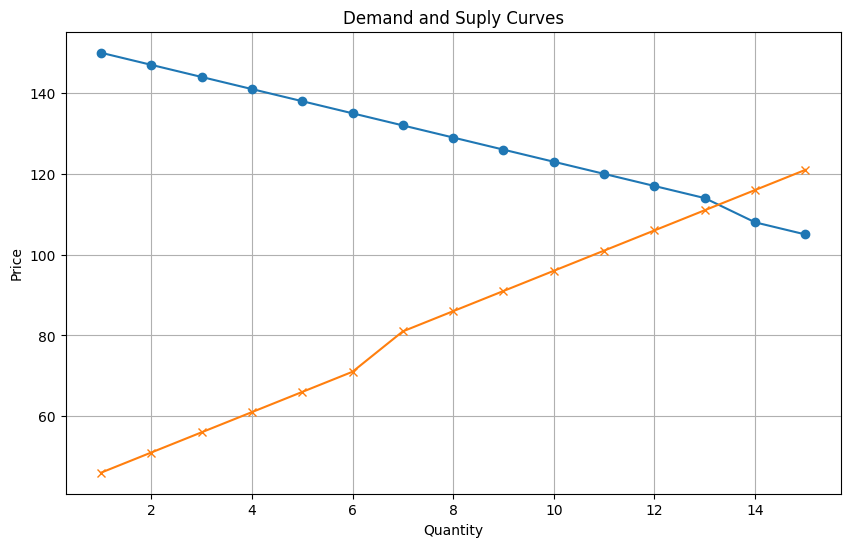

In [10]:
import matplotlib.pyplot as plt 

combined_demand = np.sort(demand_sch.flatten())[::-1] 
quantity = np.arange(1, len(combined_demand) + 1)

combined_supply = np.sort(supply_sch.flatten()) 

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(quantity, combined_demand, marker='o', label='Demand')
plt.plot(quantity, combined_supply, marker='x', label='Supply')
plt.xlabel("Quantity")
plt.ylabel("Price")
plt.title("Demand and Suply Curves")
plt.grid(True)
plt.show()


Run the GAME!

In [ ]:
import time
start_time = int(time.time()) - 60 # mark time to check costs (optional) - not actually sure how refined OpenAI's time is on this though

for _ in range(5): # limite loops in case of non converge, and noted in system prompts - could adjust

    sellers = list(MyGame.sellers.values())
    buyers = list(MyGame.buyers.values())

    combined_players = sellers + buyers

    players = random.sample(combined_players, len(combined_players))

    for i in range(len(players)):

        if isinstance(players[i], Seller) and players[i].name not in MyGame.sellers:
            continue
        if isinstance(players[i], Buyer) and players[i].name not in MyGame.buyers:
            continue

        player_type, messages = GetMessage(MyGame, players[i])

        if player_type == "Seller":
            out = seller_reply(messages)
            tool_call = out.tool_calls
            if tool_call is not None:
                my_tool = tool_call[0]
                args = json.loads(my_tool.function.arguments)
                choice = args['choice']
                if choice == 'ask':
                    price = args['price'] 
                    MyGame.update('seller', 'bid', players[i].name, price)
                else: 
                    MyGame.update('seller', 'accept', players[i].name)
        else:
            out = buyer_reply(messages)
            tool_call = out.tool_calls
            if tool_call is not None:
                my_tool = tool_call[0]
                args = json.loads(my_tool.function.arguments)
                choice = args['choice']
                if choice == 'offer':
                    price = args['price'] 
                    MyGame.update('buyer', 'bid', players[i].name, price)
                else: 
                    MyGame.update('buyer', 'accept', players[i].name)

        time.sleep(2) 

        clear_output(wait=True)  # wait=True makes the output smoother
        print(f"Loop iteration: {i}, total sales: {len(MyGame.sales)}, action: {MyGame.actions[-1] if MyGame.actions else None}")

Loop iteration: 0, total sales: 15, action: ('buyer_accept', 'B_2', 122, 'S_2')


Get costs of run

In [12]:
# get costs of game play
# Set the headers
headers = {
    "Authorization": f"Bearer {openai_admin_key}",
    "Content-Type": "application/json"
}

# Make the request
url = f"https://api.openai.com/v1/organization/costs?start_time={start_time}&limit=1"
response = requests.get(url, headers=headers)

# Check the response
if response.status_code == 200:
    print(f"${round(response.json()['data'][0]['results'][0]['amount']['value'],3)}")  # Print the response JSON data
else:
    print(f"Error: {response.status_code}")
    print(response.text)

$0.017


Plot graph of actions by step

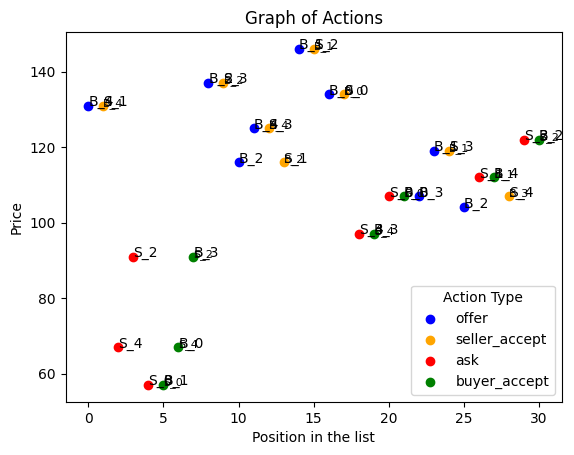

In [13]:
import matplotlib.pyplot as plt

# Define colors for each action
colors = {
    'offer': 'blue',
    'ask': 'red',
    'buyer_accept': 'green', 
    'seller_accept': 'orange'
}

x = list(range(len(MyGame.actions)))
y = [action[2] for action in MyGame.actions]

# Track which labels have been added to avoid duplicates in the legend
added_labels = set()

# Plot each action
for i, action in enumerate(MyGame.actions):
    action_type = action[0]
    color = colors[action_type]
    
    # Only add label for legend once
    label = action_type if action_type not in added_labels else None
    if label:
        added_labels.add(action_type)
    
    plt.scatter(x[i], y[i], color=color, label=label)
    plt.text(x[i], y[i], action[1])  # Display the name next to the dot

    if len(action) == 4:
        plt.text(x[i], y[i] - 0.02, action[3], color='black', fontsize=8)

# Labeling
plt.xlabel("Position in the list")
plt.ylabel("Price")
plt.title("Graph of Actions")

# Add the legend with unique labels
plt.legend(title="Action Type")

plt.show()

Save results of experiment

In [14]:
sales = MyGame.sales
actions = MyGame.actions

# Convert numpy array to list of columns
demand_curves = [[int(val) for val in column] for column in demand_sch.T]  # T is the transpose of the numpy array
supply_curves = [[int(val) for val in column] for column in supply_sch.T]

experiment_run = {
    'sales': sales,
    'actions': actions,
    'demands' : demand_curves,
    'supplies' : supply_curves
}

with open('my_SnD_experiment_data_v3.json', 'w') as f: # here I just ran three times for this notebook
    json.dump(experiment_run, f, indent=4)

Repeat games and save multiple runs of cells above (be sure to change seed at each run, though not 100% nec.), then load all below and plot together

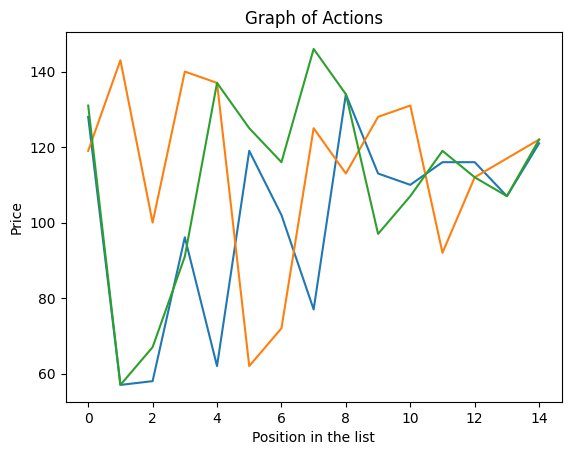

In [15]:
data_list = ['my_SnD_experiment_data_v1.json', 'my_SnD_experiment_data_v2.json', 'my_SnD_experiment_data_v3.json']

y_schedules = []

for dataset in data_list:

    with open(dataset, 'r') as f:
        data = json.load(f)

    sales = data['sales']
    sale_prices = [float(t[0]) for t in sales]

    y_schedules.append(sale_prices)

x_start = 0  # Initialize starting point for x
for y_schedule in y_schedules:
    x_end = x_start + len(y_schedule)
    x = list(range(x_start, x_end))
    
    plt.plot(x, y_schedule)
    

# Labeling and showing the plot
plt.xlabel("Position in the list")
plt.ylabel("Price")
plt.title("Graph of Actions")
plt.show()

And we see that around step/sale 8-10 we are pretty much at equilibrium! Cool!